# RNN Sentiment Analysis

Import Dependencies

In [1]:
%store -r initial_processing_df

from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, SimpleRNN, Embedding, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import random


In [68]:
df = initial_processing_df
df.head(14)

,Review,Rating,Positive,Character_Count,Word_count,id
0,nice hotel expensive parking got good deal sta...,4,1,593,87,1
1,ok nothing special charge diamond member hilto...,2,0,1689,250,2
2,nice rooms not 4* experience hotel monaco seat...,3,0,1427,217,3
3,"unique, great stay, wonderful time hotel monac...",5,1,600,89,4
4,"great stay great stay, went seahawk game aweso...",5,1,1281,191,5
5,love monaco staff husband stayed hotel crazy w...,5,1,1002,134,6
6,"cozy stay rainy city, husband spent 7 nights m...",5,1,748,101,7
7,"excellent staff, housekeeping quality hotel ch...",4,1,597,85,8
8,"hotel stayed hotel monaco cruise, rooms genero...",5,1,419,59,9
9,excellent stayed hotel monaco past w/e delight...,5,1,271,35,10


## Splitting Data to Train Test

In [3]:
x = df['Review']
y = df['Positive']

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

print("shape of x_train:", x_train.shape)
print("shape of x_test:", x_test.shape)

print("shape of y_train:", y_train.shape)
print("shape of y_test:", y_test.shape)


shape of x_train: (16392,)
shape of x_test: (4099,)
shape of y_train: (16392,)
shape of y_test: (4099,)


# More Preprocessing

It's apparent that the reviews vary in lengths, which is problematic. Neural networks cannot accept data of different lengths. Therefore, it is imperative that we standardize the length of each review. To accomplish this, we need to:

* Determine a fxied number of word.
* Tokenize the words.
* Pad the text.

## Determine Number of Words

In [5]:
# Checking mean and std
df["Word_count"].describe()

count    20491.000000
mean       104.375824
std        100.656586
min          7.000000
25%         48.000000
50%         77.000000
75%        124.000000
max       1931.000000
Name: Word_count, dtype: float64

### Visual Inspection

Upon careful examination of both visuals, it becomes apparent that 250 words represents the optimal maximum word count.

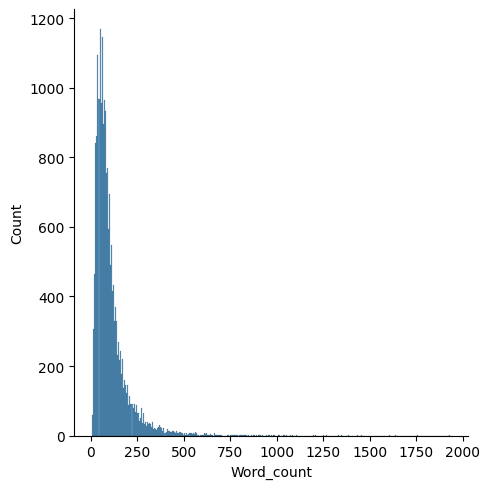

In [6]:
sns.displot(df["Word_count"])

<Axes: >

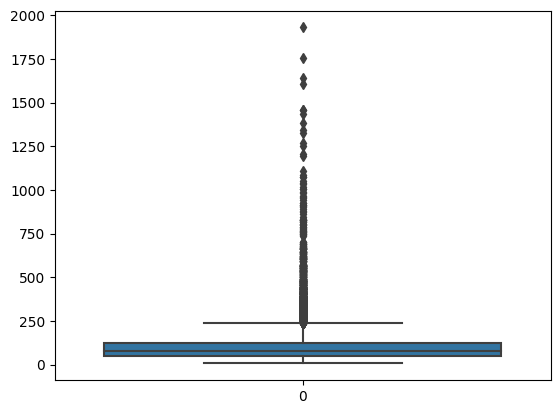

In [7]:
sns.boxplot(df["Word_count"])

### IQR Method
To ensure accuracy, I will also use the IQR method to verify the validity or proximity of my observation.

In [8]:
q1 = df["Word_count"].quantile(0.25)
q3 = df["Word_count"].quantile(0.75)
iqr = q3-q1

The upper limit, which is 238, closely aligns with my observation. Therefore, I will round it up to 250.

In [9]:
upper_limit = q3 + (1.5 * iqr)
lower_limit = q1 - (1.5 * iqr)

upper_limit, lower_limit

(238.0, -66.0)

## Tokenizing the text. Creates a word-to-index dictionary

Once a word is tokenized, the assigned number represents its frequency within the text. The number 1 corresponds to the most frequently occurring word, and so forth.

In [10]:
# This is what the words look like before getting tokenized
print(x_train[4])
print(y_train[4])

great stay great stay, went seahawk game awesome, downfall view building did n't complain, room huge staff helpful, booked hotels website seahawk package, no charge parking got voucher taxi, problem taxi driver did n't want accept voucher barely spoke english, funny thing speak arabic called started making comments girlfriend cell phone buddy, took second realize just said fact speak language face priceless, ass told, said large city, told head doorman issue called cab company promply answer did n't, apologized offered pay taxi, bucks 2 miles stadium, game plan taxi return going humpin, great walk did n't mind, right christmas wonderful lights, homeless stowed away building entrances leave, police presence not greatest area stadium, activities 7 blocks pike street waterfront great coffee shops way, hotel mantained foyer awesome, wine tasting available evening, best dog, taking st. bernard time family, safes hotel located service desk room, bathroom huge jetted tub huge, funny house kee

In [11]:
# Let's check what our vocabulary size is
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train.copy())

VOCAB_SIZE = len(tokenizer.word_index)
print("Vocabulary size:", VOCAB_SIZE)

Vocabulary size: 46656


In [12]:
VOCAB_SIZE = 46578

#, lower=True
tokenizer = Tokenizer(VOCAB_SIZE)
tokenizer.fit_on_texts(x_train)

# Providing each token an integer
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [13]:
# This is what the words look like after beeing tokenized
print(x_train[4])
print(y_train[4])

[265, 15153, 23648, 15, 1648, 121, 256, 17, 2480, 7, 2831, 5, 2318, 2831, 13325, 2, 720, 1274, 511, 395, 274, 214, 1907, 1, 119, 591]
1


## Padding the text

* If a review exceeds 250 words, we will remove the excess words.
* If a review contains less than 250 words, we will append zeros to it until it reaches a length of 750 words.

In [14]:
# Word lenghts before padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(93, 71, 183, 218, 26)

In [15]:
# Max length of words
MAXLEN = 250

x_train = keras.utils.pad_sequences(x_train, padding='post', maxlen=MAXLEN)
x_test = keras.utils.pad_sequences(x_test, padding='post', maxlen=MAXLEN)

In [16]:
# Word lenghts after padding
len(x_train[0]), len(x_train[1]), len(x_train[2]), len(x_train[3]), len(x_train[4])

(250, 250, 250, 250, 250)

In [17]:
# And this is what it looks like if we take a closer look
x_train[4]

array([  265, 15153, 23648,    15,  1648,   121,   256,    17,  2480,
           7,  2831,     5,  2318,  2831, 13325,     2,   720,  1274,
         511,   395,   274,   214,  1907,     1,   119,   591,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

## One-Hot Encoding on y

In [18]:
# The assigned number is dependent on the type of rating being used, which is currently set to 0 or 1 in this instance.
# However, it is possible to modify this.
num_classes = 2

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print(y_train.shape)
print(y_test[0])

(16392, 2)
[0. 1.]


## Resaping the data from 2D to 3D

Recurrent Neural Networks (RNNs) require 3D input because they are designed to operate on sequences of data. The 3D input tensor consists of a batch size, sequence length, and feature dimensions.

* Batch size: The number of sequences in a batch, typically represented as the first dimension of the 3D tensor.
* Sequence length: The number of time steps in each sequence, represented as the second dimension of the 3D tensor.
* Feature dimensions: The number of features or variables in each time step, represented as the third dimension of the 3D tensor.

The 3D input tensor allows RNNs to process a sequence of data over time, where each time step contains a set of features. By using a 3D input, RNNs can learn and remember patterns and dependencies across multiple time steps, which is useful in a variety of applications such as natural language processing, speech recognition, and time series forecasting.

In [19]:
x_train = np.array(x_train).reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = np.array(x_test).reshape((x_test.shape[0], x_test.shape[1], 1))

print(x_train.shape)
print("Sentences:", x_train.shape[0], "Words:", x_train.shape[1], "TimeSteps:", x_train.shape[2], "\n")
print(x_test.shape)
print("Sentences:", x_test.shape[0], "Words:", x_test.shape[1], "TimeSteps:", x_test.shape[2])

(16392, 250, 1)
Sentences: 16392 Words: 250 TimeSteps: 1 

(4099, 250, 1)
Sentences: 4099 Words: 250 TimeSteps: 1


# Model Building

In [20]:
model = tf.keras.Sequential([
tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=50, input_length=MAXLEN),
tf.keras.layers.LSTM(32),
tf.keras.layers.Dense(num_classes, activation="sigmoid"),
])
    
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 50)           2328900   
                                                                 
 lstm (LSTM)                 (None, 32)                10624     
                                                                 
 dense (Dense)               (None, 2)                 66        
                                                                 
Total params: 2,339,590
Trainable params: 2,339,590
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['accuracy'])
rnn_model_history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.2)

Epoch 1/20
410/410 [==============================] - 24s 55ms/step - loss: 0.5790 - accuracy: 0.7357 - val_loss: 0.5827 - val_accuracy: 0.7289
Epoch 2/20
410/410 [==============================] - 22s 53ms/step - loss: 0.5717 - accuracy: 0.7403 - val_loss: 0.5808 - val_accuracy: 0.7301
Epoch 3/20
410/410 [==============================] - 20s 49ms/step - loss: 0.5371 - accuracy: 0.7678 - val_loss: 0.4806 - val_accuracy: 0.7954
Epoch 4/20
410/410 [==============================] - 20s 49ms/step - loss: 0.4704 - accuracy: 0.8055 - val_loss: 0.4614 - val_accuracy: 0.8219
Epoch 5/20
410/410 [==============================] - 20s 49ms/step - loss: 0.4576 - accuracy: 0.8157 - val_loss: 0.4664 - val_accuracy: 0.8222
Epoch 6/20
410/410 [==============================] - 20s 49ms/step - loss: 0.4312 - accuracy: 0.8379 - val_loss: 0.4624 - val_accuracy: 0.8118
Epoch 7/20
410/410 [==============================] - 20s 49ms/step - loss: 0.4312 - accuracy: 0.8388 - val_loss: 0.4685 - val_accuracy:

In [22]:
results = model.evaluate(x_test, y_test)
print(results)

129/129 [==============================] - 2s 14ms/step - loss: 0.4600 - accuracy: 0.8302
[0.4599902331829071, 0.8302024602890015]


So we're scoring somewhere in the low-mid 80's. Not bad for a simple recurrent network.

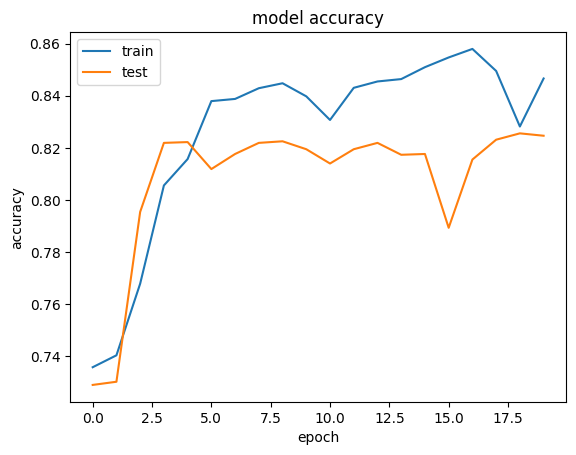

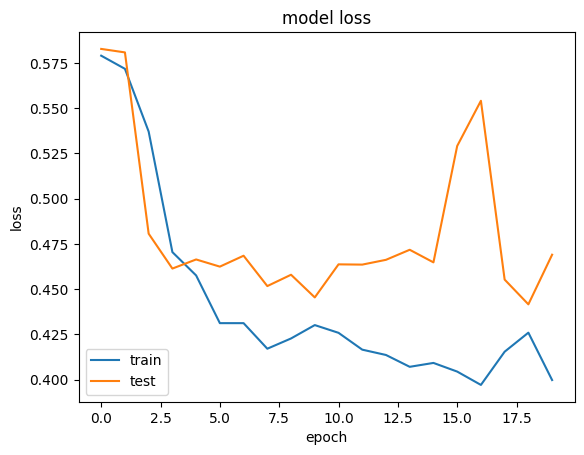

In [23]:
# Model Performance Chart

plt.plot(rnn_model_history.history['accuracy'])
plt.plot(rnn_model_history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


plt.plot(rnn_model_history.history['loss'])
plt.plot(rnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower left')
plt.show()

# Making Predictions

Next, we will utilize our neural network to predict the sentiment of our own reviews. However, since the reviews are encoded, we need to convert our new reviews into the same encoding format so that the network can process them. To accomplish this, we will load the encodings from the existing dataset and apply them to our new data.

In [43]:
# Assuming you have a Pandas DataFrame called 'df' with a column of text data called 'text'
texts = df['Review'].tolist()

# Create a tokenizer object and fit on the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Retrieve the word index dictionary
word_index = tokenizer.word_index

In [58]:
def encode_text(text):
  tokens = keras.preprocessing.text.text_to_word_sequence(text)
  tokens = [word_index[word] if word in word_index else 0 for word in tokens]
  return keras.utils.pad_sequences([tokens], maxlen=MAXLEN, padding='post')[0]

# Tokenized words
word_index

{'hotel': 1,
 'room': 2,
 'not': 3,
 'great': 4,
 "n't": 5,
 'good': 6,
 'staff': 7,
 'stay': 8,
 'did': 9,
 'just': 10,
 'nice': 11,
 'rooms': 12,
 'no': 13,
 'location': 14,
 'stayed': 15,
 'service': 16,
 'night': 17,
 'time': 18,
 'beach': 19,
 'day': 20,
 'breakfast': 21,
 'clean': 22,
 'food': 23,
 'like': 24,
 'resort': 25,
 'place': 26,
 'really': 27,
 'the': 28,
 'pool': 29,
 '2': 30,
 'friendly': 31,
 'people': 32,
 'small': 33,
 'little': 34,
 'walk': 35,
 'got': 36,
 'excellent': 37,
 'area': 38,
 'best': 39,
 'helpful': 40,
 '5': 41,
 'bar': 42,
 '3': 43,
 'restaurant': 44,
 'restaurants': 45,
 'bathroom': 46,
 'water': 47,
 'trip': 48,
 'bed': 49,
 'recommend': 50,
 'view': 51,
 'beautiful': 52,
 'floor': 53,
 'went': 54,
 'comfortable': 55,
 'desk': 56,
 'nights': 57,
 'check': 58,
 'right': 59,
 'want': 60,
 'way': 61,
 'free': 62,
 'hotels': 63,
 'better': 64,
 'city': 65,
 '4': 66,
 'away': 67,
 'wonderful': 68,
 'make': 69,
 'ç': 70,
 'booked': 71,
 'price': 72,
 'bi

In [59]:
# This is what an encoded text is going to look like. All the 0's are paddings so that we have 250 "words".
text = 'The room was so beautiful and nice. The service was amazing. 10/10'
encoded = encode_text(text)
print(encoded)

[  28    2 3441  831   52 1254   11   28   16 3441  154   84   84    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 

In [60]:
# while were at it lets make a decode function

reverse_word_index = {value: key for (key, value) in word_index.items()}

def decode_integers(integers):
    PAD = 0
    text = ""
    for num in integers:
      if num != PAD:
        text += reverse_word_index[num] + " "

    return text[:-1]
  
print(decode_integers(encoded))

the room was so beautiful and nice the service was amazing 10 10


In [67]:
# now time to make a prediction

def predict(text):
  encoded_text = encode_text(text)
  pred = np.zeros((1,250))
  pred[0] = encoded_text
  result = model.predict(pred) 
  print(result[0])

positive_review = "the service was amazing!"
predict(positive_review)

negative_review = "The room was a mess and there where no toilet paper. The service was okay."
predict(negative_review)

1/1 [==============================] - 0s 25ms/step
[0.5803006  0.43282557]
1/1 [==============================] - 0s 22ms/step
[0.7949444  0.20019138]


# test 1